In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from captum.attr import *
import quantus
import gc

In [83]:
mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 5, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 5, shuffle=False)

In [84]:
#for natural and adversarial LeNet Model 
class LeNet_normal(torch.nn.Module):
    """Network architecture from: https://github.com/ChawDoe/LeNet5-MNIST-PyTorch."""
    def __init__(self):
        super().__init__()
        self.conv_1 = torch.nn.Conv2d(1, 6, 5)
        self.pool_1 = torch.nn.MaxPool2d(2, 2)
        self.relu_1 = torch.nn.ReLU()
        self.conv_2 = torch.nn.Conv2d(6, 16, 5)
        self.pool_2 = torch.nn.MaxPool2d(2, 2)
        self.relu_2 = torch.nn.ReLU()
        self.fc_1 = torch.nn.Linear(256, 120)
        self.relu_3 = torch.nn.ReLU()
        self.fc_2 = torch.nn.Linear(120, 84)
        self.relu_4 = torch.nn.ReLU()
        self.fc_3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool_1(self.relu_1(self.conv_1(x)))
        x = self.pool_2(self.relu_2(self.conv_2(x)))
        x = x.view(x.shape[0], -1)
        x = self.relu_3(self.fc_1(x))
        x = self.relu_4(self.fc_2(x))
        x = self.fc_3(x)
        return x

In [85]:
#from rev2.cifar10.model_utils import resnet50, CIFAR10_RESNET50_CKPT_PATH

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, out_keys=None):
        out = {}
        x = self.conv1(x)
        out["c1"] = x
        x = self.bn1(x)
        out["bn1"] = x
        x = F.relu(x)
        out["r1"] = x

        x = self.layer1(x)
        out["l1"] = x
        x = self.layer2(x)
        out["l2"] = x
        x = self.layer3(x)
        out["l3"] = x
        x = self.layer4(x)
        out["l4"] = x

        x = F.avg_pool2d(x, 4)
        out["gvp"] = x
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        out["fc"] = x

        if out_keys is None:
            return x
        res = {}
        for key in out_keys:
            res[key] = out[key]
        return res


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])


def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])


def resnet50():
    return ResNet(Bottleneck, [3,4,6,3])


def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])


def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])


def test():
    net = ResNet18()
    y = net(torch.randn(1,3,32,32))
    print(y.size())

In [86]:
def load_mnist_model(path):
    model = LeNet_normal()
    model.to(device)
    model.load_state_dict(torch.load(path))
    model.to('cuda')
    model.train(False)
    return model

In [87]:
def load_cifar_model(path):
    model = resnet50()
    ckpt_dict = torch.load(path, lambda storage, loc: storage)
    model.load_state_dict(ckpt_dict)
    model.to('cuda')
    model.train(False)
    return model

In [88]:
device = "cuda"

In [89]:
path = "mnist_model.pth"
normal_model = load_mnist_model(path)
normal_model.to(device)
normal_model.eval()

LeNet_normal(
  (conv_1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_1): ReLU()
  (conv_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu_2): ReLU()
  (fc_1): Linear(in_features=256, out_features=120, bias=True)
  (relu_3): ReLU()
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (relu_4): ReLU()
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
)

In [90]:
image, label = next(iter(train_loader))
image, label = image.to(device), label.to(device)

In [91]:
images_pgd = fast_gradient_method(normal_model, image, 0.25, np.inf)
_, y_pred_pgd = normal_model(images_pgd).max(1)
images_pgd, y_pred_pgd = images_pgd.to(device), y_pred_pgd.to(device)

In [95]:
gc.collect()
torch.cuda.empty_cache()

In [96]:
# Generate normalised Saliency and Integrated Gradients attributions of the first batch of the test set.
normal_intgrad = quantus.normalise_func.normalise_by_negative(IntegratedGradients(normal_model).attribute(inputs=image, target=label, baselines=torch.zeros_like(image)).sum(axis=1).cpu().numpy())

In [97]:
# Generate normalised Saliency and Integrated Gradients attributions of the first batch of the test set.
saliency_normal_intgrad = (Saliency(normal_model).attribute(inputs=image, target=label).sum(axis=1).cpu().numpy())

/data/virtual environments/adv detection by robustness/adv_detection/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [98]:
adv_intgrad = quantus.normalise_func.normalise_by_negative(IntegratedGradients(normal_model).attribute(inputs=images_pgd.detach(), target=y_pred_pgd, baselines=torch.zeros_like(images_pgd)).sum(axis=1).cpu().numpy())

In [99]:
#load cifar model and set to eval
path = "cifar.ckpt"
model = load_cifar_model(path)
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (

In [100]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=torchvision.transforms.ToTensor())
test_loader = DataLoader(testset, shuffle=True, batch_size=5)

Files already downloaded and verified


In [101]:
image2, label2 = next(iter(test_loader))
image2, label2 = image2.to(device), label2.to(device)

In [79]:
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent,
)

def make_attack(x_batch, y_batch, eps, normal_model): 
    
    alpha = eps/10
    steps = int(alpha*eps)
    images_pgd = projected_gradient_descent(normal_model, x_batch, eps, alpha, steps, np.inf)
    _, y_pred_pgd = normal_model(images_pgd).max(1)
    index = (y_pred_pgd != y_batch)
    pgd_images = images_pgd[index]
    y_pred_pgd = y_pred_pgd[index]
    return pgd_images, y_pred_pgd

In [80]:
images_pgd2, y_pred_pgd = make_attack(image2, label2, 8/255, model)


In [102]:
images_pgd2 = fast_gradient_method(model, image2, 0.05, np.inf)
_, y_pred_pgd2 = model(images_pgd2).max(1)
images_pgd2, y_pred_pgd2 = images_pgd2.to(device), y_pred_pgd2.to(device)

In [104]:
gc.collect()
torch.cuda.empty_cache()

In [105]:
# Generate normalised Saliency and Integrated Gradients attributions of the first batch of the test set.
normal_intgrad2 = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model).attribute(inputs=image2, target=label2, baselines=torch.zeros_like(image2)).sum(axis=1).cpu().numpy())

In [74]:
adv_intgrad2 = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model).attribute(inputs=images_pgd2.detach(), target=y_pred_pgd2, baselines=torch.zeros_like(images_pgd2)).sum(axis=1).cpu().numpy())

In [75]:
#relative measure of dispersion
def compute_coef_var(attr):
    scores = []
    for i in range(len(attr)):
        a = attr[i].flatten()
        m = np.mean(a)
        st = np.std(attr[i])
        sc = m/st
        scores.append(sc)
    return scores

In [76]:
print(compute_coef_var(normal_intgrad2))

[0.03838830854504881, 0.0344326570611392, 0.05788260367676393, 0.03873523871008567, 0.03960711598927684]


In [77]:
print(compute_coef_var(adv_intgrad2))

[0.06636951398374141, 0.06509230690735228, 0.07153483985459579, 0.07212156462803765, 0.06231492585272336]


In [119]:
image, label = next(iter(train_loader))
image, label = image.to(device), label.to(device)
image2, label2 = next(iter(test_loader))
image2, label2 = image2.to(device), label2.to(device)

In [120]:
images_pgd = fast_gradient_method(normal_model, image, 0.25, np.inf)
_, y_pred_pgd = normal_model(images_pgd).max(1)
images_pgd, y_pred_pgd = images_pgd.to(device), y_pred_pgd.to(device)
images_pgd2 = fast_gradient_method(model, image2, 0.05, np.inf)
_, y_pred_pgd2 = model(images_pgd2).max(1)
images_pgd2, y_pred_pgd2 = images_pgd2.to(device), y_pred_pgd2.to(device)

In [123]:
# Generate normalised Saliency and Integrated Gradients attributions of the first batch of the test set.
normal_intgrad = quantus.normalise_func.normalise_by_negative(IntegratedGradients(normal_model).attribute(inputs=image, target=label, baselines=torch.zeros_like(image)).sum(axis=1).cpu().numpy())

In [124]:
adv_intgrad = quantus.normalise_func.normalise_by_negative(IntegratedGradients(normal_model).attribute(inputs=images_pgd.detach(), target=y_pred_pgd, baselines=torch.zeros_like(images_pgd)).sum(axis=1).cpu().numpy())

In [125]:
gc.collect()
torch.cuda.empty_cache()

In [126]:
# Generate normalised Saliency and Integrated Gradients attributions of the first batch of the test set.
normal_intgrad2 = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model).attribute(inputs=image2, target=label2, baselines=torch.zeros_like(image2)).sum(axis=1).cpu().numpy())
adv_intgrad2 = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model).attribute(inputs=images_pgd2.detach(), target=y_pred_pgd2, baselines=torch.zeros_like(images_pgd2)).sum(axis=1).cpu().numpy())


In [135]:
image2, label2 = next(iter(test_loader))
image2, label2 = image2.to(device), label2.to(device)
images_pgd2 = fast_gradient_method(model, image2, 0.05, np.inf)
_, y_pred_pgd2 = model(images_pgd2).max(1)
images_pgd2, y_pred_pgd2 = images_pgd2.to(device), y_pred_pgd2.to(device)
# Generate normalised Saliency and Integrated Gradients attributions of the first batch of the test set.
normal_intgrad2 = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model).attribute(inputs=image2, target=label2, baselines=torch.zeros_like(image2)).sum(axis=1).cpu().numpy())
adv_intgrad2 = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model).attribute(inputs=images_pgd2.detach(), target=y_pred_pgd2, baselines=torch.zeros_like(images_pgd2)).sum(axis=1).cpu().numpy())

In [141]:
image2, label2 = next(iter(test_loader))
image2, label2 = image2.to(device), label2.to(device)
images_pgd2 = fast_gradient_method(model, image2, 0.05, np.inf)
_, y_pred_pgd2 = model(images_pgd2).max(1)
images_pgd2, y_pred_pgd2 = images_pgd2.to(device), y_pred_pgd2.to(device)
# Generate normalised Saliency and Integrated Gradients attributions of the first batch of the test set.
normal_intgrad2 = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model).attribute(inputs=image2, target=label2, baselines=torch.zeros_like(image2)).sum(axis=1).cpu().numpy())
adv_intgrad2 = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model).attribute(inputs=images_pgd2.detach(), target=y_pred_pgd2, baselines=torch.zeros_like(images_pgd2)).sum(axis=1).cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


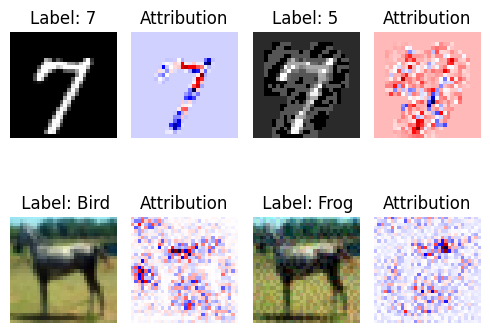

In [143]:
nr_images = 2 
i=4
j=1
fig, axes = plt.subplots(nrows=nr_images, ncols=4, figsize=(nr_images*2.5, int(nr_images*3)))
axes[0, 0].imshow((image[i].to('cpu').permute(1, 2, 0)), cmap="gray")
axes[0, 0].title.set_text(f"Label: {label[i].item()}")
axes[0, 0].axis("off")

axes[0, 1].imshow(normal_intgrad[i], cmap="seismic")
axes[0, 1].title.set_text(f"Attribution")
axes[0, 1].axis("off")
plt.tight_layout()

axes[0, 2].imshow((images_pgd[i].detach().to('cpu').permute(1, 2, 0)), cmap="gray")
axes[0, 2].title.set_text(f"Label: {y_pred_pgd[i].item()}")
axes[0, 2].axis("off")
plt.tight_layout()

axes[0, 3].imshow(adv_intgrad[i], cmap="seismic")
axes[0, 3].title.set_text(f"Attribution")
axes[0, 3].axis("off")
plt.tight_layout()
axes[1, 0].imshow((np.moveaxis((image2[j].cpu().numpy()), 0, -1)*255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
#axes[1, 0].imshow((image2[1].to('cpu').permute(1, 2, 0)), cmap="gray")
axes[1, 0].title.set_text(f" Label: Bird")
axes[1, 0].axis("off")

axes[1, 1].imshow(normal_intgrad2[j], cmap="seismic")
axes[1, 1].title.set_text(f"Attribution")
axes[1, 1].axis("off")

axes[1, 2].imshow(np.transpose((images_pgd2[j].cpu().detach().numpy()),(1,2,0)), cmap="gray")
#axes[1, 1].imshow((images_pgd2[1].detach().to('cpu').permute(1, 2, 0)), cmap="gray")
axes[1, 2].title.set_text(f" Label: Frog")
axes[1, 2].axis("off")

axes[1, 3].imshow(adv_intgrad2[j], cmap="seismic")
axes[1, 3].title.set_text(f"Attribution")
axes[1, 3].axis("off")
plt.tight_layout()
plt.show()
#fig.savefig("advsamples.pdf", format="pdf", bbox_inches="tight")

/tmp/ipykernel_51375/1605858764.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


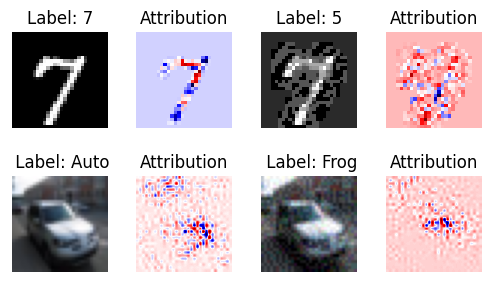

In [182]:
nr_images = 2 
i=4
j=2
fig, axes = plt.subplots(nrows=nr_images, ncols=4, figsize=(nr_images*2.5, int(nr_images*3)), constrained_layout=True)
axes[0, 0].imshow((image[i].to('cpu').permute(1, 2, 0)), cmap="gray")
axes[0, 0].title.set_text(f"Label: {label[i].item()}")
axes[0, 0].axis("off")
plt.tight_layout()

axes[0, 1].imshow(normal_intgrad[i], cmap="seismic")
axes[0, 1].title.set_text(f"Attribution")
axes[0, 1].axis("off")
plt.tight_layout()

axes[0, 2].imshow((images_pgd[i].detach().to('cpu').permute(1, 2, 0)), cmap="gray")
axes[0, 2].title.set_text(f"Label: {y_pred_pgd[i].item()}")
axes[0, 2].axis("off")
plt.tight_layout()

axes[0, 3].imshow(adv_intgrad[i], cmap="seismic")
axes[0, 3].title.set_text(f"Attribution")
axes[0, 3].axis("off")
plt.tight_layout()
axes[1, 0].imshow((np.moveaxis((image2[j].cpu().numpy()), 0, -1)*255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
#axes[1, 0].imshow((image2[1].to('cpu').permute(1, 2, 0)), cmap="gray")
axes[1, 0].title.set_text(f" Label: Auto")
axes[1, 0].axis("off")
plt.tight_layout()

axes[1, 1].imshow(normal_intgrad2[j], cmap="seismic")
axes[1, 1].title.set_text(f"Attribution")
axes[1, 1].axis("off")
plt.tight_layout()

axes[1, 2].imshow(np.transpose((images_pgd2[j].cpu().detach().numpy()),(1,2,0)), cmap="gray")
#axes[1, 1].imshow((images_pgd2[1].detach().to('cpu').permute(1, 2, 0)), cmap="gray")
axes[1, 2].title.set_text(f" Label: Frog")
axes[1, 2].axis("off")

axes[1, 3].imshow(adv_intgrad2[j], cmap="seismic")
axes[1, 3].title.set_text(f"Attribution")
axes[1, 3].axis("off")
plt.tight_layout()
plt.subplots_adjust(
                    bottom=0.1,
                    top=0.5,
                    wspace=0.3,
                    hspace=0.5)
plt.show()
fig.savefig("advsamples.pdf", format="pdf", bbox_inches="tight")

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(nr_images*2.5, int(nr_images*3)))

axes[0].imshow((image[i].to('cpu').permute(1, 2, 0)), cmap="gray")
axes[0].title.set_text(f"Label: {label[i].item()}")
axes[0].axis("off")
axes[1].imshow(normal_intgrad[i], cmap="seismic")
axes[1].title.set_text(f"Attribution")
axes[1].axis("off")
plt.tight_layout()

axes[2].imshow((images_pgd[i].detach().to('cpu').permute(1, 2, 0)), cmap="gray")
axes[2].title.set_text(f"Label: {y_pred_pgd[i].item()}")
axes[2].axis("off")
plt.tight_layout()

axes[3].imshow(adv_intgrad[i], cmap="seismic")
axes[3].title.set_text(f"Attribution")
axes[3].axis("off")
plt.tight_layout()
plt.show()
fig.savefig("advsamplesIntroMNIST.pdf", format="pdf", bbox_inches="tight")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


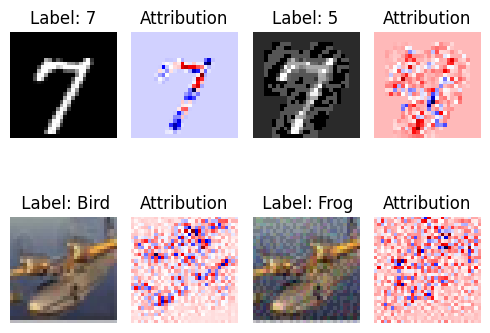

In [146]:
nr_images = 2 
i=4
j=4
fig, axes = plt.subplots(nrows=nr_images, ncols=4, figsize=(nr_images*2.5, int(nr_images*3)))
axes[0, 0].imshow((image[i].to('cpu').permute(1, 2, 0)), cmap="gray")
axes[0, 0].title.set_text(f"Label: {label[i].item()}")
axes[0, 0].axis("off")

axes[0, 1].imshow(normal_intgrad[i], cmap="seismic")
axes[0, 1].title.set_text(f"Attribution")
axes[0, 1].axis("off")
plt.tight_layout()

axes[0, 2].imshow((images_pgd[i].detach().to('cpu').permute(1, 2, 0)), cmap="gray")
axes[0, 2].title.set_text(f"Label: {y_pred_pgd[i].item()}")
axes[0, 2].axis("off")
plt.tight_layout()

axes[0, 3].imshow(adv_intgrad[i], cmap="seismic")
axes[0, 3].title.set_text(f"Attribution")
axes[0, 3].axis("off")
plt.tight_layout()
axes[1, 0].imshow((np.moveaxis((image2[j].cpu().numpy()), 0, -1)*255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
#axes[1, 0].imshow((image2[1].to('cpu').permute(1, 2, 0)), cmap="gray")
axes[1, 0].title.set_text(f" Label: Bird")
axes[1, 0].axis("off")

axes[1, 1].imshow(normal_intgrad2[j], cmap="seismic")
axes[1, 1].title.set_text(f"Attribution")
axes[1, 1].axis("off")

axes[1, 2].imshow(np.transpose((images_pgd2[j].cpu().detach().numpy()),(1,2,0)), cmap="gray")
#axes[1, 1].imshow((images_pgd2[1].detach().to('cpu').permute(1, 2, 0)), cmap="gray")
axes[1, 2].title.set_text(f" Label: Frog")
axes[1, 2].axis("off")

axes[1, 3].imshow(adv_intgrad2[j], cmap="seismic")
axes[1, 3].title.set_text(f"Attribution")
axes[1, 3].axis("off")
plt.tight_layout()
plt.show()
#fig.savefig("advsamples.pdf", format="pdf", bbox_inches="tight")

# Approach 1

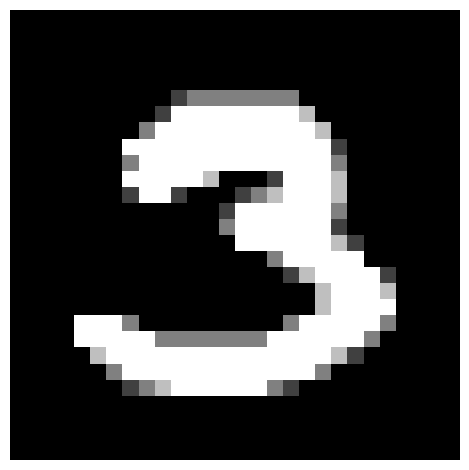

In [248]:
plt.imshow((image[1].to('cpu').permute(1, 2, 0)), cmap="gray")
plt.axis('off')
plt.tight_layout()


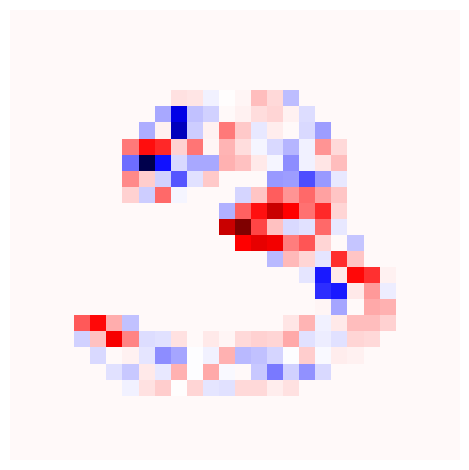

In [249]:
# feature attribution 
plt.imshow(normal_intgrad[1], cmap="seismic")
plt.axis("off")
plt.tight_layout()

In [252]:
from typing import Any, Dict, Optional, Sequence, Tuple, Union, List

def infer_attribution_axes(a_batch: np.ndarray, x_batch: np.ndarray)-> Sequence[int]:
    """
    Reference: quantus library
    Infers the axes in x_batch that are covered by a_batch.
    Parameters
    ----------
    x_batch: np.ndarray
        A np.ndarray which contains the input data that are explained.
    a_batch: np.ndarray
        An array which contains pre-computed attributions i.e., explanations.
    Returns
    -------
    np.ndarray
        The axes inferred.
    """
    # TODO: Adapt for batched processing.

    if a_batch.shape[0] != x_batch.shape[0]:
        raise ValueError(
            f"a_batch and x_batch must have same number of batches ({a_batch.shape[0]} != {x_batch.shape[0]})"
        )

    if a_batch.ndim > x_batch.ndim:
        raise ValueError(
            "Attributions need to have <= dimensions than inputs, but {} > {}".format(
                a_batch.ndim, x_batch.ndim
            )
        )

    # TODO: We currently assume here that the batch axis is not carried into the perturbation functions.
    a_shape = [s for s in np.shape(a_batch)[1:] if s != 1]
    x_shape = [s for s in np.shape(x_batch)[1:]]

    if a_shape == x_shape:
        return np.arange(0, len(x_shape))

    # One attribution value per sample
    if len(a_shape) == 0:
        return np.array([])

    x_subshapes = [
        [x_shape[i] for i in range(start, start + len(a_shape))]
        for start in range(0, len(x_shape) - len(a_shape) + 1)
    ]
    if x_subshapes.count(a_shape) < 1:

        # Check that attribution dimensions are (consecutive) subdimensions of inputs
        raise ValueError(
            "Attribution dimensions are not (consecutive) subdimensions of inputs:  "
            "inputs were of shape {} and attributions of shape {}".format(
                x_batch.shape, a_batch.shape
            )
        )
    elif x_subshapes.count(a_shape) > 1:

        # Check that attribution dimensions are (unique) subdimensions of inputs.
        # Consider potentially expanded dims in attributions.

        if a_batch.ndim == x_batch.ndim and len(a_shape) < a_batch.ndim:
            a_subshapes = [
                [np.shape(a_batch)[1:][i] for i in range(start, start + len(a_shape))]
                for start in range(0, len(np.shape(a_batch)[1:]) - len(a_shape) + 1)
            ]
            if a_subshapes.count(a_shape) == 1:

                # Inferring channel shape.
                for dim in range(len(np.shape(a_batch)[1:]) + 1):
                    if a_shape == np.shape(a_batch)[1:][dim:]:
                        return np.arange(dim, len(np.shape(a_batch)[1:]))
                    if a_shape == np.shape(a_batch)[1:][:dim]:
                        return np.arange(0, dim)

            raise ValueError(
                "Attribution axes could not be inferred for inputs of "
                "shape {} and attributions of shape {}".format(
                    x_batch.shape, a_batch.shape
                )
            )

        raise ValueError(
            "Attribution dimensions are not unique subdimensions of inputs:  "
            "inputs were of shape {} and attributions of shape {}."
            "Please expand attribution dimensions for a unique solution".format(
                x_batch.shape, a_batch.shape
            )
        )
    else:
        # Infer attribution axes.
        for dim in range(len(x_shape) + 1):
            if a_shape == x_shape[dim:]:
                return np.arange(dim, len(x_shape))
            if a_shape == x_shape[:dim]:
                return np.arange(0, dim)

    raise ValueError(
        "Attribution axes could not be inferred for inputs of "
        "shape {} and attributions of shape {}".format(x_batch.shape, a_batch.shape)
    )


In [253]:
def modify_x_based_on_attribution(x_batch, a_batch_benign, d_type, top_k = 100):
    #get attribution axes
    a_axes = infer_attribution_axes(a_batch_benign, x_batch)
    perturbed_arr = []

    #modify each sample one-by-one
    for x,a in zip(x_batch, a_batch_benign):
        #flatten the attribution 
        a = a.flatten()
        #get indices of sorted attributions (ascending)
        a_ind = np.argsort(a)
        #get indices of top_k 
        a_ix = a_ind[-top_k:]
        if d_type=="adv":
            x = x.cpu()
            x_perturbed = baseline_replacement_by_indices(arr = x.detach().numpy(), indices = a_ix, indexed_axes = a_axes, perturb_baseline = "black")
            if (x.detach().numpy().flatten() != x_perturbed.flatten()).any():
                perturbed_arr.append(torch.from_numpy(x_perturbed))
    
        else:
            x_perturbed = baseline_replacement_by_indices(arr = x.cpu().numpy(), indices = a_ix, indexed_axes = a_axes, perturb_baseline = "black")
            if (x.cpu().numpy().flatten() != x_perturbed.flatten()).any():
                perturbed_arr.append(torch.from_numpy(x_perturbed))
    
    new_batch = torch.stack(perturbed_arr)
    return new_batch.to('cuda')

In [258]:
from quantus.functions.perturb_func import baseline_replacement_by_indices

x_modified3 = modify_x_based_on_attribution(image, saliency_normal_intgrad, top_k = 180, d_type="adv")
x_modified2 = modify_x_based_on_attribution(image, normal_intgrad, top_k = 180, d_type="adv")



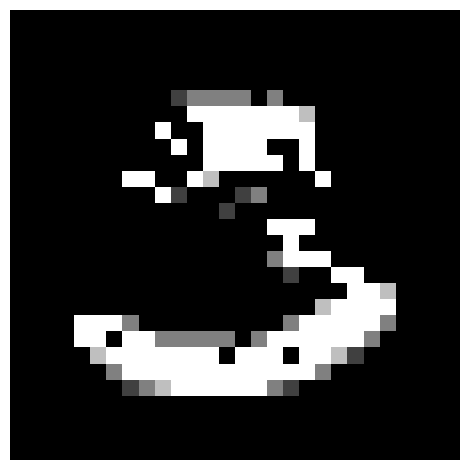

In [257]:
plt.imshow((x_modified3[1].to('cpu').permute(1, 2, 0)), cmap="gray")
plt.axis('off')
plt.tight_layout()


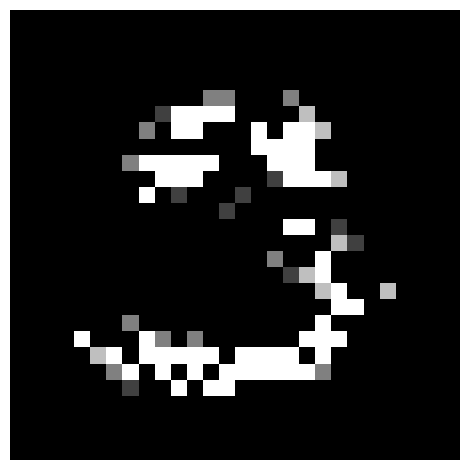

In [259]:
plt.imshow((x_modified2[1].to('cpu').permute(1, 2, 0)), cmap="gray")
plt.axis('off')
plt.tight_layout()


In [260]:
logits1 = normal_model(image)

In [261]:
logits1[1]

tensor([ -7.9159, -10.9501,  -3.7633,  15.1049, -28.9053,   4.2725, -19.0787,
         -9.4343,   0.1745,  -0.6404], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [262]:
logits2 = normal_model(x_modified2)

In [263]:
logits2[1]

tensor([-1.0950, -0.1961,  0.2684,  1.7998, -3.6449, -0.8278, -2.6800, -0.8163,
        -0.4060, -1.1356], device='cuda:0', grad_fn=<SelectBackward0>)

In [265]:
diff1 = torch.norm(logits1[1]-logits2[1],p=1)

In [266]:
diff1

tensor(91.3649, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

# CW plots for CIFAR

In [12]:
import torch


In [13]:
#load cifar model and set to eval
path = "cifar.ckpt"
model = load_cifar_model(path)
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (

In [14]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=torchvision.transforms.ToTensor())
test_loader = DataLoader(testset, shuffle=True, batch_size=5)

Files already downloaded and verified


In [15]:
image2, label2 = next(iter(test_loader))
image2, label2 = image2.to(device), label2.to(device)

In [16]:
from art.attacks.evasion import BasicIterativeMethod
from art.attacks.evasion import CarliniLInfMethod
from art.estimators.classification import PyTorchClassifier


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
classifier = PyTorchClassifier(
    model=model, clip_values=(0, 1), loss=criterion, optimizer=optimizer, input_shape=(3, 32, 32),
        nb_classes=10,
)

In [20]:
attack = CarliniLInfMethod(classifier, confidence = 0)

In [21]:
attack1 = CarliniLInfMethod(classifier, confidence = 50)

In [22]:
def make_cw_attack(attack, x_batch, y_batch, model):
    #convert tensor to numpy
    #x_batch=x_batch.to('cuda')
    #_, y_pred_pgd = normal_model(x_batch).max(1)
    x_batch = x_batch.cpu().numpy()
    x_test_adv = attack.generate(x=x_batch)
    #convert the nd array back to tensor
    x_test = torch.from_numpy(x_test_adv).to('cuda')
    _, y_test = model(x_test).max(1)
    #index = (y_test != y_batch)
    #adv_images = x_test[index]
    #y_pred_adv = y_test[index]
    return x_test, y_test

In [23]:
len(image2), label2

(5, tensor([0, 6, 3, 7, 2], device='cuda:0'))

In [24]:
images_cw,y_pred_cw = make_cw_attack(attack, image2, label2, model)

C&W L_inf:   0%|          | 0/5 [00:00<?, ?it/s]

In [25]:
y_pred_cw

tensor([1, 2, 5, 5, 3], device='cuda:0')

In [26]:
images_cw2,y_pred_cw2 = make_cw_attack(attack1, image2, label2, model)

C&W L_inf:   0%|          | 0/5 [00:00<?, ?it/s]

In [27]:
y_pred_cw2

tensor([1, 2, 5, 5, 3], device='cuda:0')

In [28]:
images_cw, y_pred_cw = images_cw.to(device), y_pred_cw.to(device)
images_cw2, y_pred_cw2 = images_cw2.to(device), y_pred_cw2.to(device)

In [30]:
import gc 
gc.collect()
torch.cuda.empty_cache()

In [32]:
from captum.attr import *
import quantus

In [33]:
# Generate normalised Saliency and Integrated Gradients attributions of the first batch of the test set.
normal_intgrad = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model).attribute(inputs=image2, target=label2, baselines=torch.zeros_like(image2)).sum(axis=1).cpu().numpy())

In [35]:
adv_intgrad1 = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model).attribute(inputs=images_cw.detach(), target=y_pred_cw, baselines=torch.zeros_like(images_cw)).sum(axis=1).cpu().numpy())

In [36]:
adv_intgrad2 = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model).attribute(inputs=images_cw2.detach(), target=y_pred_cw2, baselines=torch.zeros_like(images_cw2)).sum(axis=1).cpu().numpy())

In [43]:
images_fgsm = fast_gradient_method(model, image2, 0.03, np.inf)
_, y_pred_fgsm = model(images_fgsm).max(1)
label2,  y_pred_fgsm

(tensor([0, 6, 3, 7, 2], device='cuda:0'),
 tensor([6, 2, 3, 5, 3], device='cuda:0'))

In [44]:
adv_intgrad3 = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model).attribute(inputs=images_fgsm.detach(), target=y_pred_fgsm, baselines=torch.zeros_like(images_fgsm)).sum(axis=1).cpu().numpy())

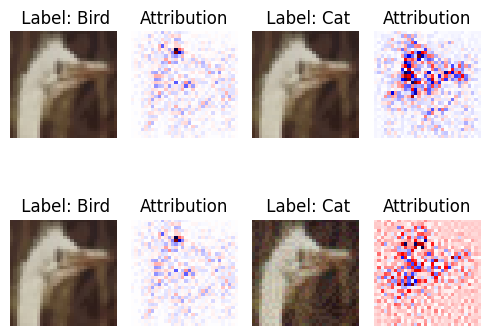

In [48]:
nr_images = 2 
fig, axes = plt.subplots(nrows=nr_images, ncols=4, figsize=(nr_images*2.5, int(nr_images*3)))
axes[0, 0].imshow((np.moveaxis((image2[4].cpu().numpy()), 0, -1)*255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
#axes[1, 0].imshow((image2[1].to('cpu').permute(1, 2, 0)), cmap="gray")
axes[0, 0].title.set_text(f" Label: Bird")
axes[0, 0].axis("off")

axes[0, 1].imshow(normal_intgrad[4], cmap="seismic")
axes[0, 1].title.set_text(f"Attribution")
axes[0, 1].axis("off")

axes[0, 2].imshow(np.transpose((images_cw[4].cpu().detach().numpy()),(1,2,0)), cmap="gray")
#axes[1, 1].imshow((images_pgd2[1].detach().to('cpu').permute(1, 2, 0)), cmap="gray")
axes[0, 2].title.set_text(f" Label: Cat")
axes[0, 2].axis("off")

axes[0, 3].imshow(adv_intgrad1[4], cmap="seismic")
axes[0, 3].title.set_text(f"Attribution")
axes[0, 3].axis("off")
plt.tight_layout()

axes[1, 0].imshow((np.moveaxis((image2[4].cpu().numpy()), 0, -1)*255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
axes[1, 0].title.set_text(f" Label: Bird")
axes[1, 0].axis("off")

axes[1, 1].imshow(normal_intgrad[4], cmap="seismic")
axes[1, 1].title.set_text(f"Attribution")
axes[1, 1].axis("off")

axes[1, 2].imshow(np.transpose((images_fgsm[4].cpu().detach().numpy()),(1,2,0)), cmap="gray")
axes[1, 2].title.set_text(f" Label: Cat")
axes[1, 2].axis("off")

axes[1, 3].imshow(adv_intgrad3[4], cmap="seismic")
axes[1, 3].title.set_text(f"Attribution")
axes[1, 3].axis("off")
plt.tight_layout()
plt.show()



fig.savefig("CWadvsamples.pdf", format="pdf", bbox_inches="tight")